In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_excel("../data/raw/entrenamiento.xlsx")
df = df.rename(columns={"C7.1": "C8", "des": "QUALITY"})

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
C1,3684.0,6.857166,0.846430,3.800000,6.300000,6.800000,7.300000,14.200000
C2,3664.0,0.421440,0.988207,0.076961,0.190620,0.231112,0.285179,6.913737
C3,3648.0,0.284054,0.086887,0.000000,0.239017,0.277632,0.329304,0.802002
C4,3636.0,6.424642,5.084063,0.600000,1.700000,5.300000,9.900000,65.800000
C5,3659.0,40.685294,25.106022,0.020000,33.000000,41.000000,49.000000,346.000000
C6,3655.0,35.216142,17.167346,2.000000,23.000000,34.000000,46.000000,289.000000
C7,3645.0,4.885591,0.341723,2.302585,4.691348,4.912655,5.129899,6.089045
C8,3646.0,65.824651,245.359289,0.987110,0.991800,0.994100,0.996825,1001.000000
C9,3658.0,3.188291,0.152155,2.720000,3.090000,3.180000,3.280000,3.820000
C10,3639.0,0.395421,0.074535,0.198851,0.343590,0.385262,0.438255,0.732368


In [4]:
df_no_missing = df.dropna()

# DISTANCIAS

### Distancia Euclidea

In [5]:
# Estandarizar las características
features = df_no_missing.drop(columns=["QUALITY"])
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Calcular la distancia euclidiana de cada punto al origen
distances = np.linalg.norm(features_standardized, axis=1)

# Definir umbral
threshold = distances.mean() + 3 * distances.std()

# Detectar outliers
index_euclidean = np.where(distances > threshold)[0]

print(f"Se han detectado {len(index_euclidean)} outliers.")

Se han detectado 30 outliers.


### Distancia MInkowski P

In [6]:
from scipy.spatial import distance

# Selecciona solo las columnas numéricas
numerical_cols = df_no_missing.select_dtypes(include=[np.number]).columns

# Calcula la distancia de Minkowski con p=3 desde la mediana
medians = df_no_missing[numerical_cols].median()
minkowski_distances = df_no_missing[numerical_cols].apply(lambda row: distance.minkowski(row, medians, p=3), axis=1)

# Establece un umbral para considerar un punto como outlier
threshold = minkowski_distances.mean() + 3 * minkowski_distances.std()

index_minkowski = df_no_missing[minkowski_distances > threshold]
print(f"Number of outliers detected using Minkowski distance: {index_minkowski.shape[0]}")

Number of outliers detected using Minkowski distance: 102


### Distancia Manhattan

In [7]:
from scipy.spatial.distance import cityblock

# Calcular la distancia de Manhattan para cada punto respecto a la mediana
median_point = np.median(features_standardized, axis=0)
manhattan_distances = [cityblock(x, median_point) for x in features_standardized]

# Establecer un umbral para considerar un punto como outlier
# Podemos usar, por ejemplo, el percentil 95 como umbral
threshold = np.percentile(manhattan_distances, 95)
index_manhattan = np.where(manhattan_distances > threshold)

print(f"Se han detectado {len(index_manhattan[0])} outliers usando la distancia de Manhattan.")

Se han detectado 90 outliers usando la distancia de Manhattan.


### Distancia del Coseno

In [8]:
from scipy.spatial.distance import cosine

# Calcular la similitud del coseno para cada punto respecto a la mediana
median_point = np.median(features_standardized, axis=0)
cosine_similarities = [1 - cosine(x, median_point) for x in features_standardized]

# Establecer un umbral para considerar un punto como outlier
# Aquí, podemos usar, por ejemplo, el percentil 5 como umbral (buscamos valores bajos de similitud)
threshold = np.percentile(cosine_similarities, 5)
index_cosine = np.where(cosine_similarities < threshold)

print(f"Se han detectado {len(index_cosine[0])} outliers usando la distancia del coseno.")

Se han detectado 90 outliers usando la distancia del coseno.


### Distancia Mahalanobis

In [9]:
from scipy.stats import chi2

# Calcular la distancia de Mahalanobis
cov_matrix = np.cov(features_standardized, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mean_centered_data = features_standardized - np.mean(features_standardized, axis=0)
mahalanobis_distances = np.sqrt(np.sum(mean_centered_data @ inv_cov_matrix * mean_centered_data, axis=1))

# Establecer umbral basado en la distribución chi-cuadrado
alpha = 0.01  # nivel de significancia
critical_value = chi2.ppf((1 - alpha), df=features_standardized.shape[1])
index_mahalanobis = np.where(mahalanobis_distances > np.sqrt(critical_value))

print(f"Se han detectado {len(index_mahalanobis[0])} outliers usando la distancia de Mahalanobis.")

Se han detectado 145 outliers usando la distancia de Mahalanobis.


# PROBABILIDAD

### Z-score

In [10]:
from scipy import stats


def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    return np.where(z_scores > threshold)


# Aplicar la función de detección de outliers
numeric_cols = df_no_missing.select_dtypes(include=[np.number]).columns.tolist()
index_zscore = detect_outliers_zscore(df_no_missing[numeric_cols])

print(f"Total de outliers detectados: {len(np.unique(index_zscore[0]))}")

Total de outliers detectados: 281


### Distribucion Normal

In [11]:
def detect_outliers_normal_distribution(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    outliers = []
    for i in data:
        z_score = (i - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers


# Aplicar la función de detección de outliers
outliers_dict = {}
for col in numeric_cols:
    outliers = detect_outliers_normal_distribution(df_no_missing[col])
    outliers_dict[col] = outliers

# Contar el número total de outliers detectados
index_normal = sum([len(val) for val in outliers_dict.values()])
print(f"Total de outliers detectados: {index_normal}")

Total de outliers detectados: 312


### Shapiro-Wilk

In [12]:
from scipy.stats import shapiro

# Realizar el test de Shapiro-Wilk para cada columna numérica
shapiro_results = {}
for col in numeric_cols:
    stat, p_value = shapiro(df_no_missing[col])
    shapiro_results[col] = (stat, p_value)

# Mostrar los resultados
for col, (stat, p_value) in shapiro_results.items():
    print(f"Columna {col}: Estadístico={stat:.5f}, p-value={p_value:.5f}")


Columna C1: Estadístico=0.98047, p-value=0.00000
Columna C2: Estadístico=0.22718, p-value=0.00000
Columna C3: Estadístico=0.96341, p-value=0.00000
Columna C4: Estadístico=0.90363, p-value=0.00000
Columna C5: Estadístico=0.74388, p-value=0.00000
Columna C6: Estadístico=0.90208, p-value=0.00000
Columna C7: Estadístico=0.93096, p-value=0.00000
Columna C8: Estadístico=0.24382, p-value=0.00000
Columna C9: Estadístico=0.98671, p-value=0.00000
Columna C10: Estadístico=0.97349, p-value=0.00000
Columna C11: Estadístico=0.94999, p-value=0.00000
Columna QUALITY: Estadístico=0.88914, p-value=0.00000


# Regresion/Reconstruccion

In [13]:
X = df_no_missing.drop("QUALITY", axis=1)
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

In [14]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Autoencoder

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Definir el tamaño de nuestra codificación
encoding_dim = 5  # por ejemplo

# Definir la entrada
input_layer = Input(shape=(X_train_scaled.shape[1],))

# Definir la codificación
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Definir la decodificación
decoded = Dense(X_train_scaled.shape[1], activation='sigmoid')(encoded)

# Completar el autoencoder
autoencoder = Model(input_layer, decoded)

# Crear un modelo separado que devuelva la codificación
encoder = Model(input_layer, encoded)

2023-10-01 15:30:36.322025: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-01 15:30:36.351034: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-01 15:30:36.351057: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-01 15:30:36.351074: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-01 15:30:36.355992: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-01 15:30:36.356294: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [16]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history = autoencoder.fit(X_train_scaled, X_train_scaled,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(X_test_scaled, X_test_scaled))

Epoch 1/50
5/5 [==============================] - 0s 20ms/step - loss: 0.0976 - val_loss: 0.0964
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0967 - val_loss: 0.0955
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0958 - val_loss: 0.0946
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0948 - val_loss: 0.0936
Epoch 5/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0939 - val_loss: 0.0926
Epoch 6/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0928 - val_loss: 0.0916
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0918 - val_loss: 0.0905
Epoch 8/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0907 - val_loss: 0.0894
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0895 - val_loss: 0.0882
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0883 - val_loss: 0.0869
Epoch 11/50
5/5 [=====================

In [17]:
# Obtener las reconstrucciones para el conjunto de prueba
reconstructions = autoencoder.predict(X_test_scaled)

# Calcular el error de reconstrucción
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)
mse

17/17 [==============================] - 0s 490us/step


array([0.01200913, 0.01938941, 0.01726408, 0.0172113 , 0.06919375,
       0.01528822, 0.01692051, 0.02563102, 0.01860111, 0.01429133,
       0.02153415, 0.07846661, 0.0714642 , 0.01228675, 0.01609001,
       0.01986771, 0.01305008, 0.04044024, 0.02796231, 0.01856372,
       0.02290652, 0.03442885, 0.01380301, 0.02639093, 0.025762  ,
       0.02076   , 0.01379812, 0.01365318, 0.01389562, 0.02216399,
       0.0472026 , 0.02343494, 0.01821321, 0.04211366, 0.02466381,
       0.00858787, 0.02676548, 0.01688172, 0.02254111, 0.03089927,
       0.01800637, 0.02080951, 0.01847883, 0.01604855, 0.0248256 ,
       0.05600726, 0.05532328, 0.03087657, 0.01192927, 0.01502083,
       0.04833842, 0.02453066, 0.0334179 , 0.01334092, 0.05115951,
       0.01225892, 0.02128179, 0.01704311, 0.03607432, 0.02540939,
       0.01210321, 0.01962718, 0.0092093 , 0.01249466, 0.021895  ,
       0.01213595, 0.01684822, 0.01648738, 0.05225796, 0.0156033 ,
       0.03211882, 0.0117288 , 0.01229176, 0.01388731, 0.02363

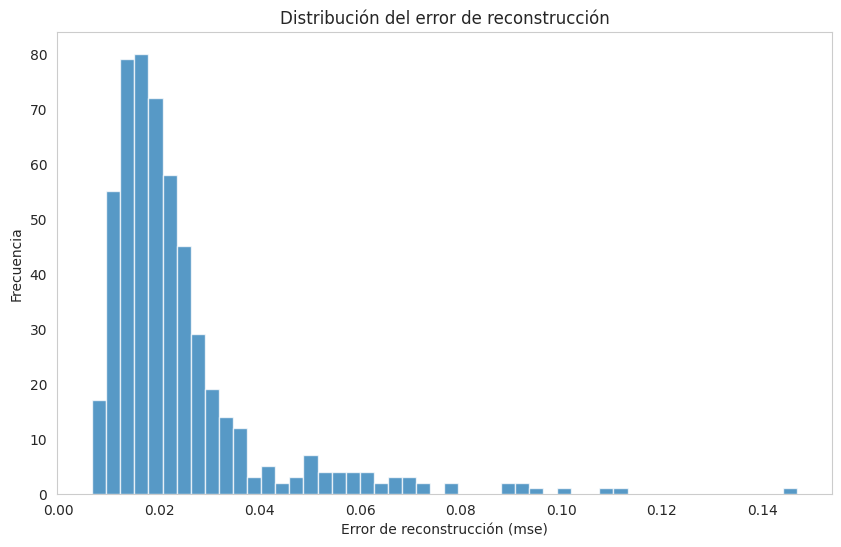

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50, alpha=0.75)
plt.xlabel('Error de reconstrucción (mse)')
plt.ylabel('Frecuencia')
plt.title('Distribución del error de reconstrucción')
plt.grid()
plt.show()

El límite superior es: 0.04324264569460887
Los índices de los outliers son: (array([  4,  11,  12,  30,  45,  46,  50,  54,  68,  91, 103, 105, 141,
       153, 160, 168, 171, 174, 175, 181, 185, 205, 255, 259, 271, 287,
       295, 297, 307, 319, 337, 347, 351, 373, 378, 392, 396, 406, 435,
       441, 460, 465, 471, 492, 508, 509, 519, 520, 524]),)


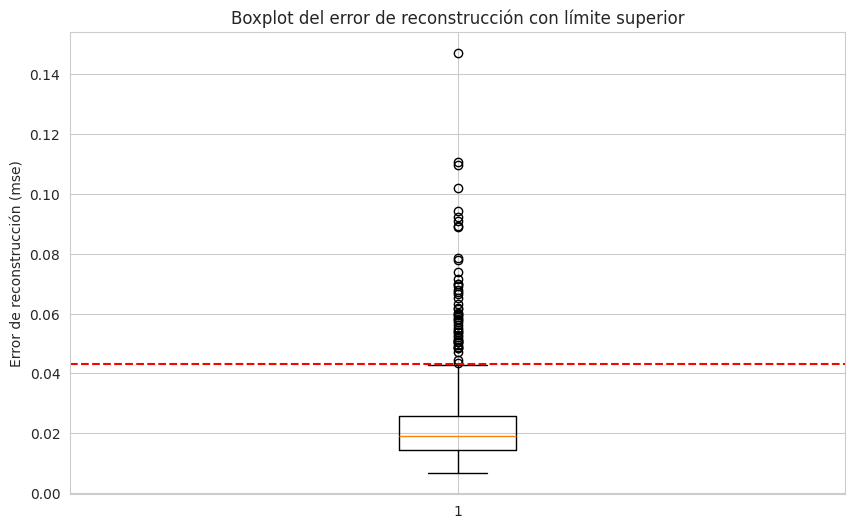

In [19]:
import numpy as np

# Paso 1: Calcular Q1 y Q3
Q1 = np.percentile(mse, 25)
Q3 = np.percentile(mse, 75)

# Paso 2: Calcular IQR
IQR = Q3 - Q1

# Paso 3: Definir el límite superior
upper_limit = Q3 + 1.5 * IQR

# Paso 4: Identificar valores atípicos
outliers = np.where(mse > upper_limit)

print(f"El límite superior es: {upper_limit}")
print(f"Los índices de los outliers son: {outliers}")

# Visualizar el límite superior en un boxplot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(mse)
plt.axhline(y=upper_limit, color='r', linestyle='--')
plt.ylabel('Error de reconstrucción (mse)')
plt.title('Boxplot del error de reconstrucción con límite superior')
plt.show()

In [20]:
# Identificar los índices de los outliers
index_encoder = np.where(mse > upper_limit)

# Calcular el número de outliers
num_outliers = len(index_encoder[0])

print(f"El número de outliers es: {num_outliers}")

El número de outliers es: 49


In [21]:
import numpy as np

# Obtener índices de outliers y no-outliers basados en el criterio de MSE
sorted_indices = np.argsort(mse)
outlier_indices = sorted_indices[-47:]  # Los 47 índices con MSE más altos
non_outlier_indices = sorted_indices[:-47]

random_outlier_samples = np.random.choice(outlier_indices, 5, replace=False)
random_non_outlier_samples = np.random.choice(non_outlier_indices, 5, replace=False)

# Imprime las observaciones seleccionadas al azar
print("Observaciones etiquetadas como outliers:")
print(df.iloc[random_outlier_samples])

print("\nObservaciones etiquetadas como no-outliers:")
print(df.iloc[random_non_outlier_samples])

Observaciones etiquetadas como outliers:
      C1        C2        C3    C4    C5    C6        C7       C8    C9  \
392  7.1  0.223144  0.223144   1.6  46.0   NaN  5.204007  0.99250  3.20   
12   8.0  0.239017  0.223144  19.1  45.0  50.0  5.342334  1.00051  3.05   
287  7.7  0.157004  0.418710   5.9  17.0  21.0  4.442651  0.99290  3.14   
68   7.0  0.198851  0.246860  10.6  39.0  32.0  4.770685  0.99355  3.05   
297  6.3  0.182322  0.314811  11.8   NaN  58.0  4.875197  0.99519  3.20   

          C10   C11  QUALITY  
392  0.350657  11.0        7  
12   0.405465   9.2        6  
287  0.336472  11.9        7  
68   0.438255  11.5        7  
297  0.300105  10.8        5  

Observaciones etiquetadas como no-outliers:
      C1        C2        C3   C4     C5    C6        C7         C8    C9  \
463  6.6  0.207014  0.277632  1.5  41.00   8.0  4.290459    0.98949  3.22   
344  5.1  0.418710  0.058269  2.7  52.00  30.0  4.382027    0.99320  3.32   
66   7.9  0.165514  0.307485  NaN  58.00  31.0

In [22]:
df_no_missing = df_no_missing.reset_index(drop=True)

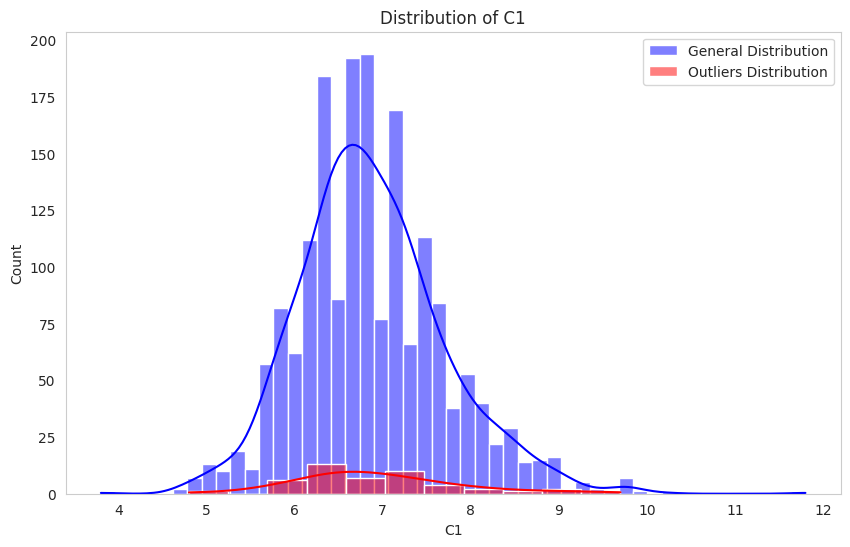

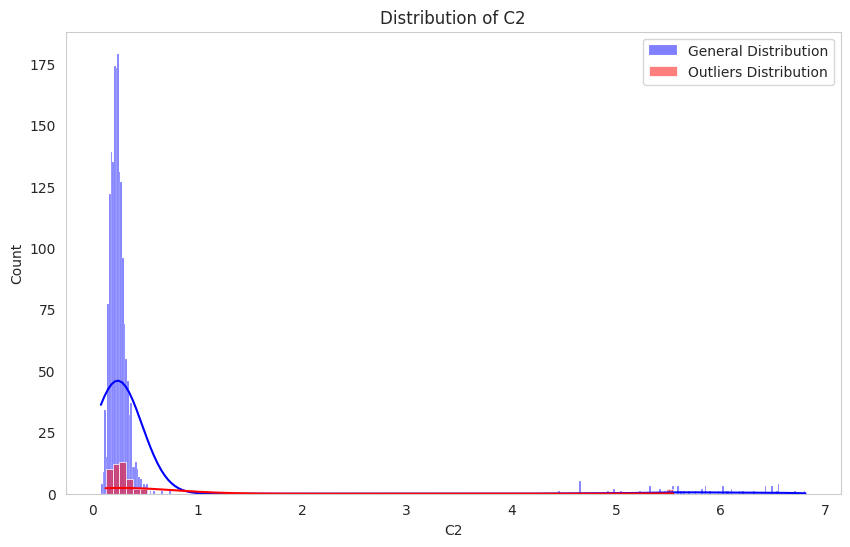

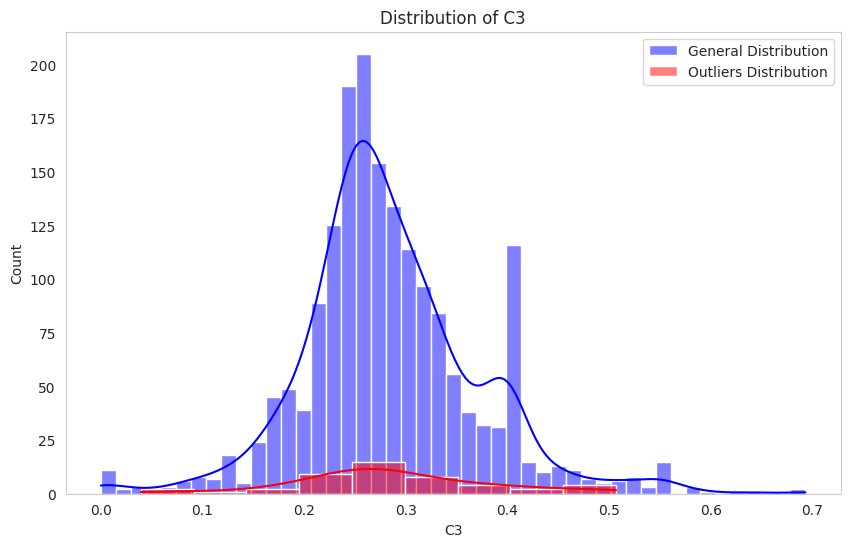

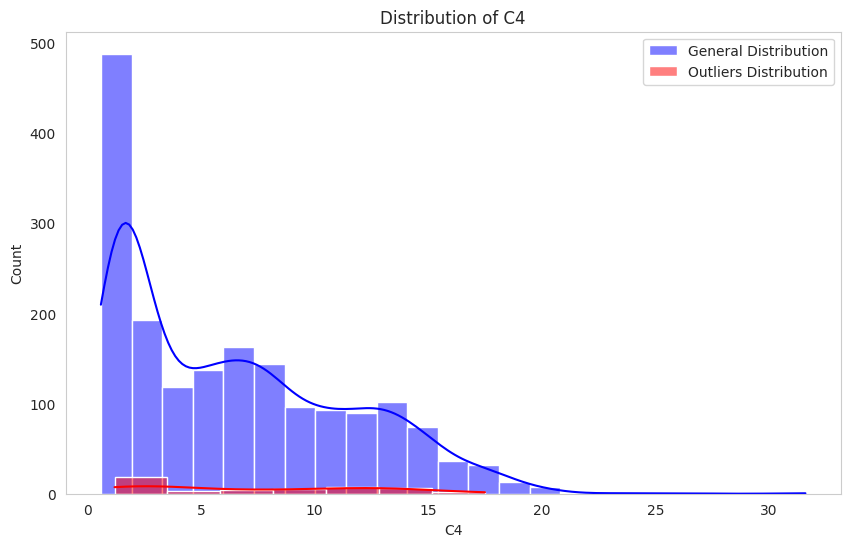

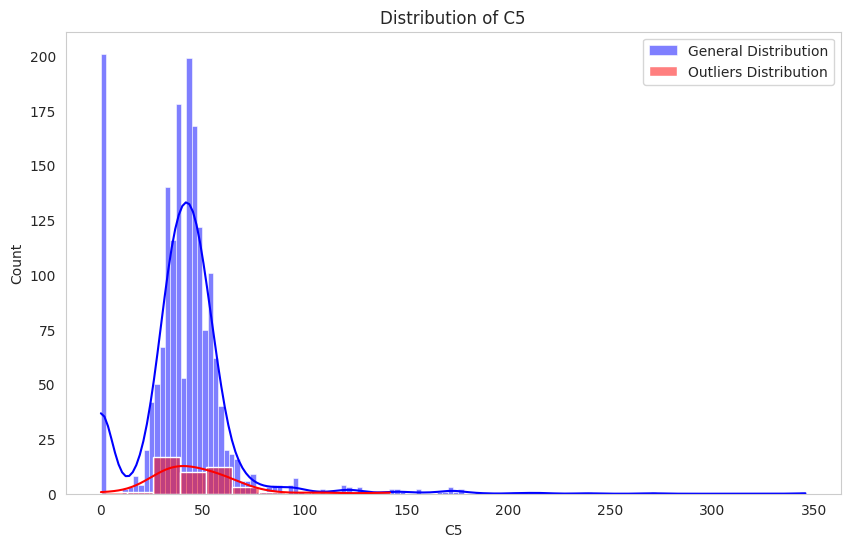

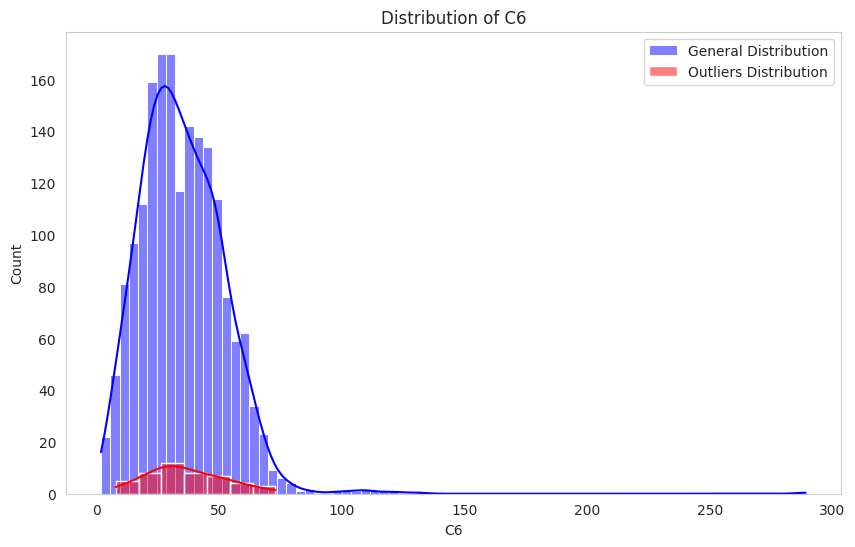

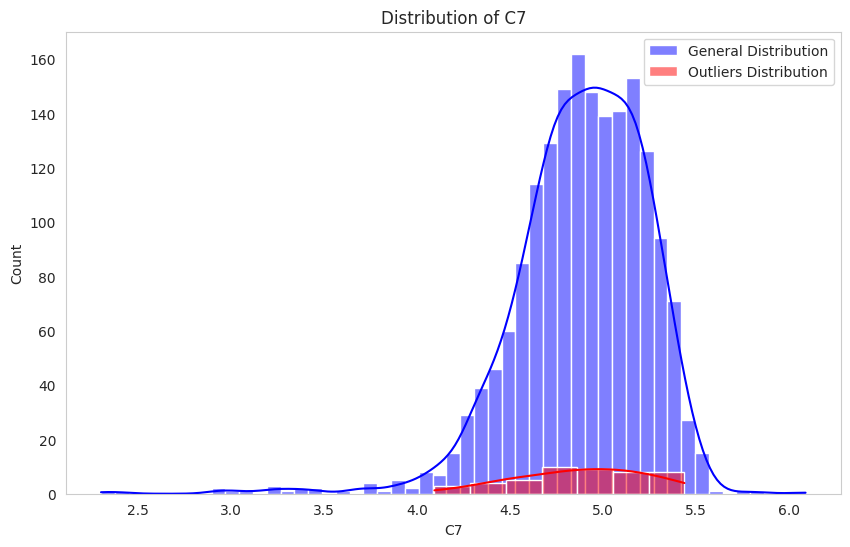

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar las observaciones etiquetadas como outliers
outliers_data = df_no_missing.loc[outlier_indices]

# Especificar las columnas que deseas visualizar
columns_to_plot = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]

for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    
    # Histograma general
    sns.histplot(df_no_missing[column], color='blue', kde=True, label='General Distribution', alpha=0.5)
    
    # Histograma de outliers
    sns.histplot(outliers_data[column], color='red', kde=True, label='Outliers Distribution', alpha=0.5)
    
    plt.title(f"Distribution of {column}")
    plt.legend()
    plt.grid()
    plt.show()

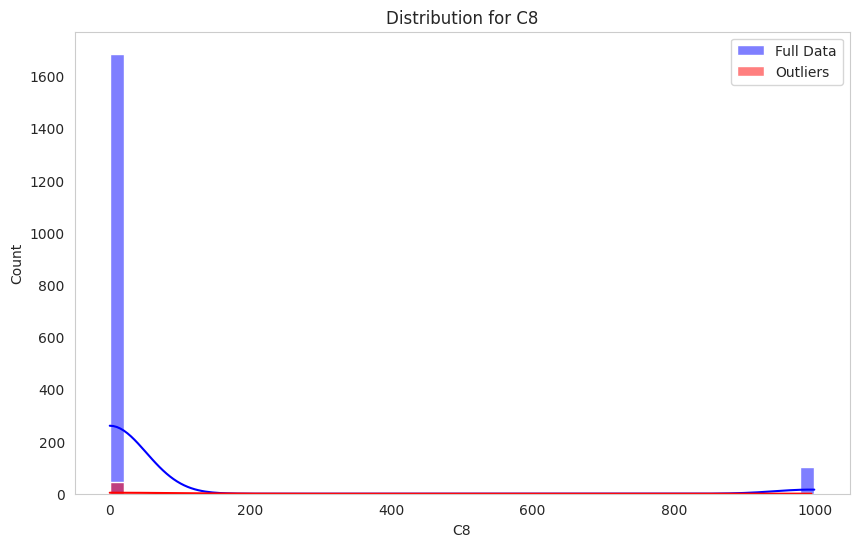

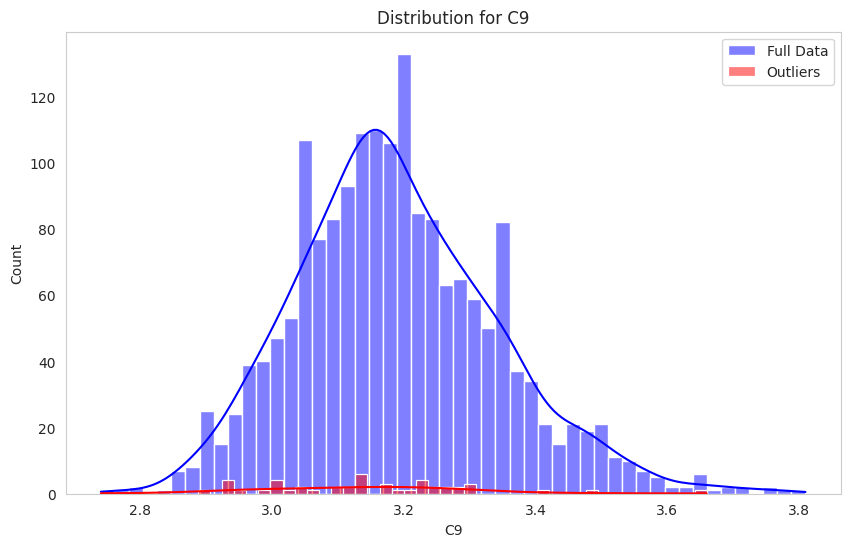

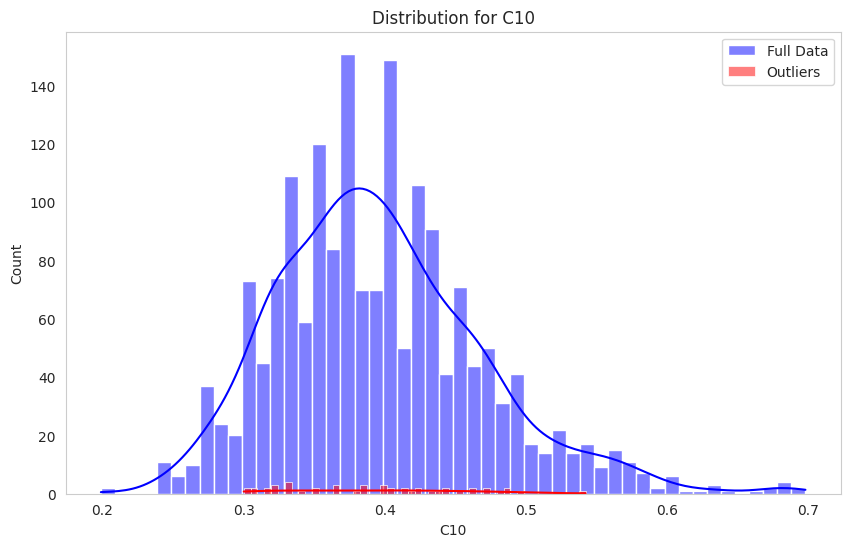

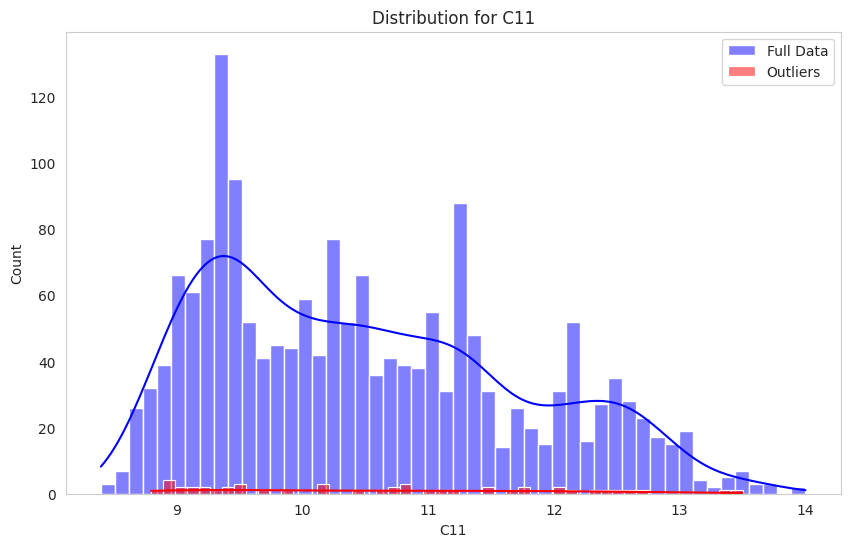

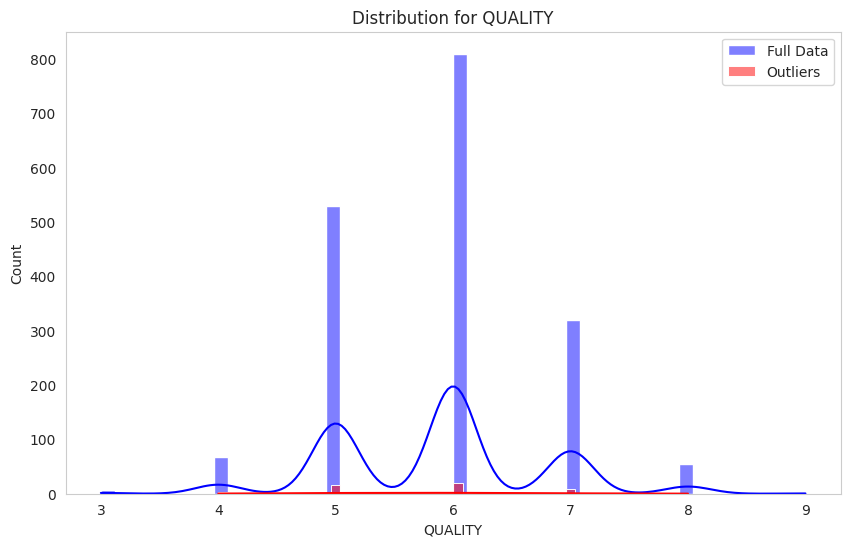

In [24]:
# Crear el DataFrame outliers_df
outliers_df = df_no_missing.loc[outlier_indices]

# Visualizar las distribuciones de las observaciones etiquetadas como outliers (continuando desde C8)
cols_to_plot = ['C8', 'C9', 'C10', 'C11', 'QUALITY']

for col in cols_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_no_missing[col], bins=50, kde=True, color='blue', label='Full Data')
    sns.histplot(outliers_df[col], bins=50, kde=True, color='red', label='Outliers')
    plt.title(f'Distribution for {col}')
    plt.legend()
    plt.grid()
    plt.show()

# Algoritmos

### K-Means

In [25]:
from sklearn.cluster import KMeans
from scipy.spatial import distance

# Ajustar KMeans
kmeans = KMeans(n_clusters=5)  # El número de clusters puede necesitar ser ajustado
kmeans.fit(df_no_missing)

# Calcular distancia de cada punto a su centroide
distances = []
for i in range(len(df_no_missing)):
    point = df_no_missing.iloc[i].values
    centroid = kmeans.cluster_centers_[kmeans.labels_[i]]
    distances.append(distance.euclidean(point, centroid))

# Identificar outliers
threshold = np.percentile(distances, 95)  # O 99 dependiendo de cuántos outliers quieras detectar
index_kmeans = df_no_missing[distances > threshold]

print(f"K-Means ha detectado {len(index_kmeans)} outliers.")

K-Means ha detectado 90 outliers.


### GMM

In [26]:
from sklearn.mixture import GaussianMixture

# Ajustar GMM
gmm = GaussianMixture(n_components=5)  # El número de componentes puede necesitar ser ajustado
gmm.fit(df_no_missing)

# Calcular scores
scores = gmm.score_samples(df_no_missing)

# Identificar outliers
threshold = np.percentile(scores, 5)  # Los 5% de puntos con los scores más bajos
index_gmm = df_no_missing[scores < threshold]

print(f"GMM ha detectado {len(index_gmm)} outliers.")

GMM ha detectado 90 outliers.


### DBSCAN

In [27]:
from sklearn.cluster import DBSCAN

# Ajustar DBSCAN
dbscan = DBSCAN()
clusters = dbscan.fit_predict(df_no_missing)

# Identificar outliers
index_dbscan = df_no_missing[clusters == -1]

print(f"DBSCAN ha detectado {len(index_dbscan)} outliers.")

DBSCAN ha detectado 1788 outliers.


### LOF

In [52]:
from sklearn.neighbors import LocalOutlierFactor

# Ajustar LOF
lof = LocalOutlierFactor()
outlier_flags = lof.fit_predict(df_no_missing)

# Identificar outliers
index_lof = df_no_missing[outlier_flags == -1]

print(f"LOF ha detectado {len(index_lof)} outliers.")

LOF ha detectado 52 outliers.
